# Logistic Noise Experiment
This notebook contains the code required to run the experiment that shows that our algorithm can still perform even when given Laplacian noise. 

In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython

from delphi.stats.linear_regression import TruncatedLinearRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'logs'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'


base_distribution = Uniform(0, 1)
transforms_ = [SigmoidTransform().inv]
logistic = TransformedDistribution(base_distribution, transforms_)


In [14]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 100,
    "lr": 1e-1,
    "var_lr": 1e-1,
    "var_": 1,
    "trials": 20,
    "norm": False,
    "workers": 8,
    "steps": 2500,
    "x_lower": -10,
    "x_upper": 10,
    'lower': -1, 
    'upper': 1,
    "lower": -1,
    "upper": 1,
#     'out_dir': '<PROVIDE OUT DIRECTORY FOR EXPERIMENT LOGS HERE>',
    'out_dir': '/Users/patroklos/Desktop/exp/unknown_log',
    'val': .1, 
    'n': 100,
    'tol': 1e-1,
#     'exp': '<PROVIDE EXPERIMENT NAME HERE>'
    'exp': 'log_again',
    'normalize': True,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for a simple example experiment. For this experiment, we will sample our input features from a $N(0, I)$, our ground-truth parameters from a $Unif(-1, 1)$, and our noise from a Laplace distribution with variance 5.

gt weight:  Parameter containing:
tensor([[0.2658]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.5685]], requires_grad=True)
alpha:  tensor([0.3590])
gt ols coef:  [[0.23742865]]
gt ols intercept:  [-0.56901014]
trunc ols coef:  [[0.08854566]]
trunc ols intercept:  [1.2322183]


Text(0, 0.5, 'y')

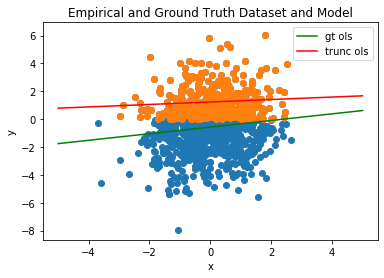

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(args.lower, args.upper)
m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
phi = oracle.Left_Regression(Tensor([0.0]))

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = ch.ones(1)
# noise_scale = ch.sqrt(noise_var/2)
# laplace = Laplace(ch.zeros(1), noise_scale)
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + logistic.sample(ch.Size([X.size(0)]))[...,None]
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

We now observe that the norm of the truncated x covariates is bounded by 1. 

Now, we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([1.2869])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

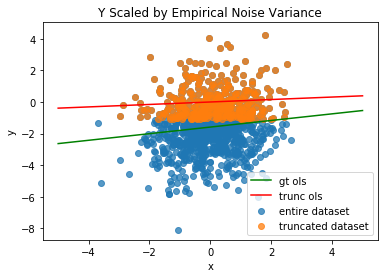

In [4]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

emp_stand_noised = (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, gt_emp_stand.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_emp_stand_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([1.2869])
reg noise var:  tensor([3.1614])


Text(0, 0.5, 'y')

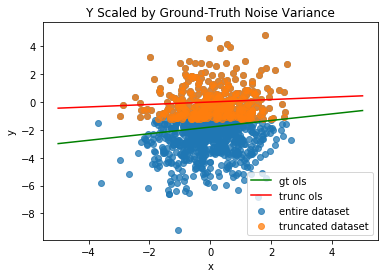

In [5]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, gt_stand.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_stand_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [6]:
emp_scale_phi = oracle.Left_Regression((phi.left - trunc_ols.intercept_) / ch.sqrt(emp_noise_var))
known_emp_trunc_reg = TruncatedLinearRegression(phi=emp_scale_phi, 
                                            alpha=alpha, 
                                            noise_var=ch.ones(1, 1), 
                                            normalize=args.normalize, 
                                            custom_lr_multiplier='adam', 
                                            val=25,
                                            bs=1, 
                                            iter_=2,
                                            num_samples=10)
known_emp_trunc_reg.fit(x_trunc, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.coef_ * ch.sqrt(emp_noise_var))
known_emp_bias_unnorm = known_emp_trunc_reg.intercept_ * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

/opt/anaconda3/lib/python3.7/site-packages/delphi/stats/linear_regression.py:130: UserWarning: max l2 feature norm larger than one, procedure may not perform as expected
  warnings.warn("max l2 feature norm larger than one, procedure may not perform as expected")


Text(17.200000000000003, 0.5, 'y')

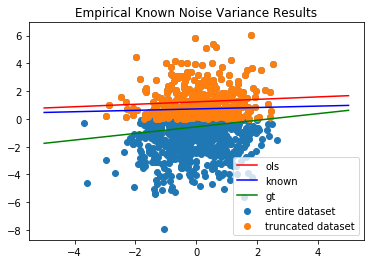

In [7]:


plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')

plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results")
ax.set_xlabel("x")
ax.set_ylabel("y")

We now run our procedure for truncated regression with known variance, assuming that we are given the ground-truth noise variance.

In [8]:
# stand_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
# known_trunc_reg = TruncatedRegression(phi=stand_phi, alpha=alpha, unknown=False, val=int(args.val*x_trunc.size(0)), bs=args.bs, n=args.n, tol=args.tol, steps=args.steps)
# known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

# known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
# known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var) + trunc_ols.intercept_


scale_phi = oracle.Left_Regression((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
known_trunc_reg = TruncatedLinearRegression(phi=scale_phi, 
                                            alpha=alpha, 
                                            noise_var=ch.ones(1, 1), 
                                            normalize=args.normalize, 
#                                             custom_lr_multiplier='adam', 
                                            val=25,
                                            bs=10, 
                                            iter_=2,
                                            num_samples=100)
known_trunc_reg.fit(x_trunc, stand_y_trunc)

known_w_unnorm = (known_trunc_reg.coef_ * ch.sqrt(noise_var))
known_bias_unnorm = known_trunc_reg.intercept_ * ch.sqrt(noise_var) + trunc_ols.intercept_

/opt/anaconda3/lib/python3.7/site-packages/delphi/stats/linear_regression.py:130: UserWarning: max l2 feature norm larger than one, procedure may not perform as expected
  warnings.warn("max l2 feature norm larger than one, procedure may not perform as expected")


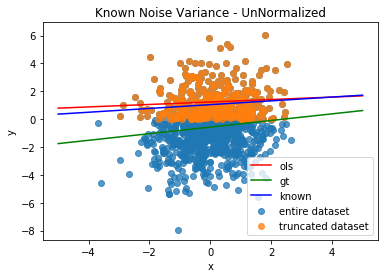

In [9]:
# ax = plt.subplot(1, 1, 1)
# plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
# plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
# plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
# plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
# plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
# plt.legend()
# plt.title("Known Noise Variance - Normalized")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_w_unnorm + known_bias_unnorm).numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [10]:
unknown_trunc_reg = TruncatedLinearRegression(phi=emp_scale_phi, 
                                            alpha=alpha, 
                                            normalize=args.normalize, 
                                            custom_lr_multiplier='adam', 
                                            val=25,
                                            bs=10, 
                                            iter_=2,
                                            var_lr=1e-3,
                                            num_samples=10)
unknown_trunc_reg.fit(x_trunc, emp_stand_y_trunc)

unknown_weight = unknown_trunc_reg.coef_  * ch.sqrt(emp_noise_var)
unknown_bias = unknown_trunc_reg.intercept_ * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

/opt/anaconda3/lib/python3.7/site-packages/delphi/stats/linear_regression.py:130: UserWarning: max l2 feature norm larger than one, procedure may not perform as expected
  warnings.warn("max l2 feature norm larger than one, procedure may not perform as expected")


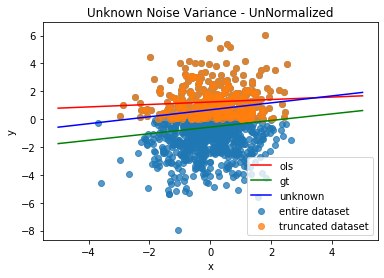

In [11]:
# ax = plt.subplot(1, 1, 1)
# plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
# plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
# plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
# plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
# plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
# plt.legend()
# ax.set_title("Unknown Noise Variance - Normalized")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight + unknown_bias), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Add Logistic Noise and Truncate at Various Parameters C

In [13]:
w_lower, w_upper = -1, 1
d, k = 2, 1

# generate logisitic distributed data for experiment
def generate_data(): 


    # distribution for generating feature vectors
    W = Uniform(w_lower, w_upper)
#     dist = Uniform(-5, 5)
    
    with ch.no_grad():
        # generate ground truth
        gt = ch.nn.Linear(in_features=d, out_features=k)
        gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
        gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) 

        m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
        X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
        y = gt(X)
        noised = y + logistic.sample(ch.Size([X.size(0)]))[...,None]

        return X, noised    

log_noise_var = Tensor([(1**2 * math.pi**2) / 3])

In [15]:
C = [-2.5, -2, -1.75, -1.5, -1.25, -1.0]

# create store and add table
store = Store(args.out_dir + '/' + args.exp)
store.add_table(TABLE_NAME, { 
    'ols_r2': float,
    'ols_param_mse': float,
    'ols_var_l1': float,
    'known_r2': float,
    'known_param_mse': float,
    'known_time': int,
    'unknown_r2': float, 
    'unknown_param_mse': float,
    'unknown_var_l1': float,
    'unknown_time': int,
    'trunc_reg_r2': float,
    'trunc_reg_param_mse': float, 
    'trunc_reg_var_l1': float,
    'trunc_reg_time': int,
    'alpha': float, 
    'c': float,
    'num_samples': int,
    'noise_var': float, 
})


for i in range(args.trials):
   
    X, noised = generate_data()
        
    # iterate over truncation parameter C
    for c in C: 
        phi = oracle.Left_Regression(c)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        val = int(args.val*x_trunc.size(0))
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - log_noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })

        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = (y_trunc - ols.intercept_) / ch.sqrt(log_noise_var)
        # standardize noised by the empirical noise variance
        st = datetime.datetime.now()
        known_trunc_reg = TruncatedLinearRegression(oracle.Left_Regression((c - ols.intercept_) /ch.sqrt(log_noise_var)), 
                                                    alpha=alpha, 
                                                    noise_var=ch.ones(1, 1), 
                                                    normalize=args.normalize, 
        #                                             custom_lr_multiplier='adam', 
                                                    val=25,
                                                    bs=1, 
                                                    iter_=2,
                                                    num_samples=10)
        known_trunc_reg.fit(x_trunc, stand_y_trunc)
        total_time = int((datetime.datetime.now() - st).total_seconds())
        
        w, w0 = (known_trunc_reg.coef_ * ch.sqrt(log_noise_var)), (known_trunc_reg.intercept_ * ch.sqrt(noise_var) + ols.intercept_)[None,...]
        known_params = ch.cat([w, w0], dim=1).flatten()

        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - ols.intercept_) / ch.sqrt(emp_noise_var)
        
        # truncated regression with unknown variance
        st = datetime.datetime.now()
        unknown_trunc_reg = TruncatedLinearRegression(
                                            phi=oracle.Left_Regression((phi.left - ols.intercept_)/ ch.sqrt(emp_noise_var)),
                                            alpha=alpha, 
                                            normalize=args.normalize, 
                                            custom_lr_multiplier='adam', 
                                            val=25,
                                            bs=10, 
                                            iter_=2,
                                            var_lr=1e-3,
                                            num_samples=50)
        unknown_trunc_reg.fit(x_trunc, emp_stand_y_trunc)
        total_time = int((datetime.datetime.now() - st).total_seconds())
        
        w, w0 = (unknown_trunc_reg.coef_ * ch.sqrt(emp_noise_var)) , (unknown_trunc_reg.intercept_ * ch.sqrt(emp_noise_var) + ols.intercept_)
        unknown_params = ch.cat([w, w0], dim=1).flatten()

        # unknown results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_trunc_reg.variance * emp_noise_var - log_noise_var)),
            'unknown_time': total_time, 
        })
        
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(c), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        total_time = int((datetime.datetime.now() - st).total_seconds())
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_l1': ch.abs(trunc_res[-1].pow(2)[None,...] - log_noise_var),
            'trunc_reg_time': total_time, 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': float(log_noise_var), 
            'c': c,
        })
        IPython.display.clear_output()
        
        # append row to table
        store[TABLE_NAME].flush_row()
store.close()    

/opt/anaconda3/lib/python3.7/site-packages/delphi/stats/linear_regression.py:130: UserWarning: max l2 feature norm larger than one, procedure may not perform as expected
  warnings.warn("max l2 feature norm larger than one, procedure may not perform as expected")


/opt/anaconda3/lib/python3.7/site-packages/delphi/stats/linear_regression.py:130: UserWarning: max l2 feature norm larger than one, procedure may not perform as expected
  warnings.warn("max l2 feature norm larger than one, procedure may not perform as expected")


KeyboardInterrupt: 

In [25]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 1/1 [00:00<00:00, 72.46it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,trunc_reg_r2,trunc_reg_param_mse,trunc_reg_var_l1,trunc_reg_time,alpha,c,num_samples,noise_var,exp_id
0,0.046313,0.031695,1.042017,0.069539,0.003101,0,0.060605,0.024231,0.948324,0,0.069836,0.002873,0.240548,0,0.927,-2.50,927,3.289868,a05669dd-2e10-41db-92fd-a782763424e2
1,0.021036,0.061742,1.212266,0.053022,0.021825,0,0.065436,0.011028,1.063684,0,0.055525,0.020933,0.052606,0,0.884,-2.00,884,3.289868,a05669dd-2e10-41db-92fd-a782763424e2
2,-0.005143,0.091994,1.326536,0.067543,0.006915,0,0.058914,0.020974,1.200470,0,0.050327,0.026668,0.119620,0,0.847,-1.75,847,3.289868,a05669dd-2e10-41db-92fd-a782763424e2
3,-0.028480,0.121155,1.382096,0.066896,0.006644,0,-0.026646,0.108746,1.229571,0,-0.025645,0.112503,0.634085,0,0.820,-1.50,820,3.289868,a05669dd-2e10-41db-92fd-a782763424e2
4,-0.087180,0.189827,1.505722,0.059032,0.015210,0,-0.011971,0.097851,1.384441,0,-0.001895,0.082818,0.557631,0,0.760,-1.25,760,3.289868,a05669dd-2e10-41db-92fd-a782763424e2


In [131]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'c', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
#     temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [132]:
cols = ['known_param_mse', 'c', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [133]:
cols = ['ols_param_mse', 'ols_var_l1', 'c', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
#     temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


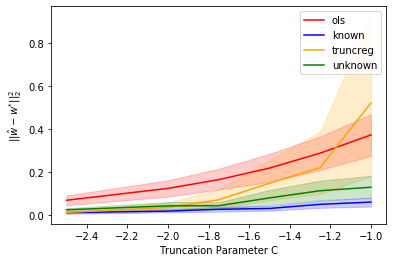

[Text(0, 0.5, 'L2 Distance to Ground-Truth'),
 Text(0.5, 0, 'Truncation Parameter C')]

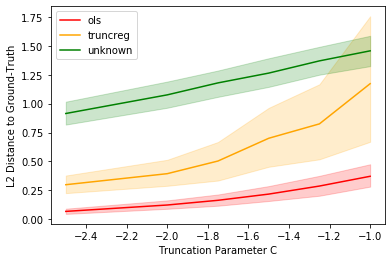

In [31]:
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=logs, x='c', y='known_param_mse', label='known', color='blue')
sns.lineplot(data=logs, x='c', y='trunc_reg_param_mse', color='orange', label='truncreg')
ax = sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown', color='green')

ax.set(xlabel='Truncation Parameter C', ylabel='$||\hat w - w^{*}||^{2}_{2}$')
plt.show()

sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=logs, x='c', y='trunc_reg_var_l1', color='orange', label='truncreg')
ax = sns.lineplot(data=logs, x='c', y='unknown_var_l1', label='unknown', color='green')

ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')

In [28]:
logs[logs.c == -1.0].alpha

5      0.708
11     0.569
17     0.847
23     0.730
29     0.847
35     0.661
41     0.793
47     0.528
53     0.620
59     0.657
65     0.828
71     0.529
77     0.637
83     0.512
89     0.793
95     0.509
101    0.555
107    0.878
113    0.611
119    0.848
Name: alpha, dtype: float64